# PREPROCESSING

In [ ]:
# processes a textfile according with skip-gram algorithm
# returns a list in the following format [[7,4],[42,44], ...]
from preprocessing import Preprocess
from utils import createWordPairs
import pickle

# Variables: 
#     threshold: how many emojis count as a sequence
#     window_size: determine how far to the left and right of center_word the skip-gram algo forms word_pairs
threshold = 2
window_size = 8

indexes = Preprocess('./data/initializationSet.txt', threshold)
trainingCorpus = Preprocess('./data/trainingSet.txt', threshold)
validationCorpus = Preprocess('./data/validationSet.txt', threshold)
trainingPairs = createWordPairs(indexes, trainingCorpus, window_size)
validationPairs = createWordPairs(indexes, validationCorpus, window_size)

indexes_out = open("./Preprocess_Files/indexes.pickle","wb")
trainingCorpus_out = open("./Preprocess_Files/trainingCorpus.pickle","wb")
validationCorpus_out = open("./Preprocess_Files/validationCorpus.pickle","wb")
trainingPairs_out = open("./Preprocess_Files/trainingPairs.pickle","wb")
validationPairs_out = open("./Preprocess_Files/validationPairs.pickle","wb")

pickle.dump(indexes, indexes_out)
pickle.dump(trainingCorpus, trainingCorpus_out)
pickle.dump(validationCorpus, validationCorpus_out)
pickle.dump(trainingPairs, trainingPairs_out)
pickle.dump(validationPairs, validationPairs_out)

indexes_out.close()
trainingCorpus_out.close()
validationCorpus_out.close()
trainingPairs_out.close()
validationPairs_out.close()

In [4]:
import pickle
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sampler import ImbalancedDatasetSampler
from dataset import LoadedDataSet
from model import Word2Vec
from utils import EarlyStopping

# importing preprocessing_files
indexes_in = open("./Preprocess_Files/indexes.pickle","rb")
trainingCorpus_in = open("./Preprocess_Files/trainingCorpus.pickle","rb")
validationCorpus_in = open("./Preprocess_Files/validationCorpus.pickle","rb")
trainingPairs_in = open("./Preprocess_Files/trainingPairs.pickle","rb")
validationPairs_in = open("./Preprocess_Files/validationPairs.pickle","rb")
indexes = pickle.load(indexes_in)
trainingCorpus = pickle.load(trainingCorpus_in)
validationCorpus = pickle.load(validationCorpus_in)
trainingPairs = pickle.load(trainingPairs_in)
validationPairs = pickle.load(validationPairs_in)
indexes_in.close()
trainingCorpus_in.close()
validationCorpus_in.close()
trainingPairs_in.close()
validationPairs_in.close()

# HyperParams
dimensionSize = 300
num_epochs = 600
lr = 0.5
batchSize = 150
patience = 5
save_name = "noNumpy.w2v"
verbose = True

trainingDataset = LoadedDataSet(trainingPairs)
sampler = ImbalancedDatasetSampler(trainingDataset)

trainingLoader = DataLoader(trainingDataset, batchSize, sampler=sampler) 
validationDataset = LoadedDataSet(validationPairs)
validationLoader = DataLoader(validationDataset, batchSize, shuffle=True) 

# TRAINING

In [5]:
# best trainable after extending the data_rate_limit..
# use terminal cmd w/ MAC: "jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000"

model = Word2Vec(indexes.vocabulary_size, dimensionSize)
optimizer = torch.optim.Adam(model.parameters(), lr)
# Variables for Scheduler:
# 3,6,10,20
# 5,10,40              52
# comparable with much larger set? can I make conclusions here?
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,10,20], gamma=0.1)

# initialize the early_stopping object
early_stopping = EarlyStopping(patience, verbose, save_name)
avg_train_losses = []
avg_valid_losses = []

for e in range(1, num_epochs + 1):
    train_losses = []
    valid_losses = []
    for param_group in optimizer.param_groups:
        print(param_group['lr'])    
#         ###################
#         # train the model #
#         ###################     
    for i, (data, target) in enumerate(trainingLoader):
        model.train()
        optimizer.zero_grad()
        loss = model.forward(data, target)       
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()     
  
        ######################    
        # validate the model #
        ######################
    for i, (data, target) in enumerate(validationLoader): 
        model.eval()
        with torch.no_grad():
            loss = model.forward(data, target)       
        valid_losses.append(loss.item())

    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    scheduler.step()
    
###################################################    
#   visual Update regarding the current epoch   #
###################################################    
    epoch_len = len(str(num_epochs))
    print_msg = (f'[{e:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                 f'train_loss: {np.average(train_losses):.5f} ' +
                 f'valid_loss: {np.average(valid_losses):.5f}')
    print(print_msg)
    
        ##################
        # Early Stopping #
        ##################
    early_stopping(np.average(valid_losses), model)
    if early_stopping.early_stop:
        print("EARLY STOPPING!")
        break

0.5
[  1/600] train_loss: 3.86248 valid_loss: 4.47258
Validation loss decreased (inf --> 4.472579).  Saving model ...
0.5
[  2/600] train_loss: 3.25538 valid_loss: 4.39424
Validation loss decreased (4.472579 --> 4.394238).  Saving model ...
0.5
[  3/600] train_loss: 3.16392 valid_loss: 4.36100
Validation loss decreased (4.394238 --> 4.361001).  Saving model ...
0.5
[  4/600] train_loss: 3.12141 valid_loss: 4.36275
EarlyStopping counter: 1 out of 5
0.05
[  5/600] train_loss: 3.04837 valid_loss: 4.30353
Validation loss decreased (4.361001 --> 4.303529).  Saving model ...
0.05
[  6/600] train_loss: 3.02666 valid_loss: 4.29724
Validation loss decreased (4.303529 --> 4.297238).  Saving model ...
0.05


KeyboardInterrupt: 

# Visualizing the Loss and the Early Stopping Checkpoint¶

In [ ]:
import matplotlib.pyplot as plt

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(3.5, 7) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('./SOFTMAX_trained/plots/loss_plot.png', bbox_inches='tight')

# LOADING & EVALUATING TRAINED MODEL

In [6]:
# loads the weights of a saved model and calculates and prints the following metrics: SpearManRank, MSE, MAE 
# look @ the data with TensorBoardX "tensorboard --logdir runs"

import torch
import os
from evaluation import Metrics

loadedModel = torch.load(os.path.join("SOFTMAX_trained", "noNumpy.w2v"))
Metrics(loadedModel.weight.data.cpu().numpy(), indexes)

the cosine similarity between 🇬🇧 and 🇺🇸 could not be computed.
the cosine similarity between 🏅 and 🇺🇸 could not be computed.
the cosine similarity between 🇺🇸 and ❤ could not be computed.
the cosine similarity between 🇺🇸 and 💥 could not be computed.
the cosine similarity between 🎤 and 🇳🇬 could not be computed.
the cosine similarity between 🇳🇬 and 📲 could not be computed.
the cosine similarity between 👇 and 🇳🇬 could not be computed.
the cosine similarity between 🎧 and 🇳🇬 could not be computed.
the cosine similarity between 🇳🇬 and 🎶 could not be computed.
the cosine similarity between 👏 and ↪ could not be computed.

mein Spearman: 0.46396928155487416
sein Spearman: 0.7590552598973165
mein MAE ist 0.34152071209826385
sein MAE ist 0.24206827309236947
mein MSE ist 0.16214684391402837
sein MSE ist 0.08023220381526104


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U4 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [7]:
model = loadedModel.weight.data.cpu().numpy()

In [8]:
model[1][0]

61.942554

In [9]:
model.shape

(1111, 300)

In [15]:
weights = model.reshape(-1)

In [ ]:
import matplotlib.pyplot as plt
pp.figure(figsize=(10,10))

pp.plot(model[0])
pp.show()

(array([1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00,
        1.0000e+00, 2.0000e+00, 5.0000e+00, 1.0000e+00, 4.0000e+00,
        4.0000e+00, 2.0000e+00, 4.0000e+00, 8.0000e+00, 5.0000e+00,
        7.0000e+00, 5.0000e+00, 7.0000e+00, 1.1000e+01, 4.0000e+00,
        1.6000e+01, 1.0000e+01, 1.0000e+01, 1.4000e+01, 1.1000e+01,
        1.6000e+01, 1.9000e+01, 1.6000e+01, 1.8000e+01, 2.3000e+01,
        3.3000e+01, 2.1000e+01, 2.2000e+01, 2.8000e+01, 3.1000e+01,
        3.5000e+01, 4.9000e+01, 4.6000e+01, 5.8000e+01, 5.6000e+01,
        6.4000e+01, 6.8000e+01, 7.5000e+01, 6.5000e+01, 8.2000e+01,
        8.5000e+01, 8.8000e+01, 9.7000e+01, 1.1600e+02, 1.0300e+02,
        1.1800e+02, 1.5500e+02, 1.4300e+02, 1.51

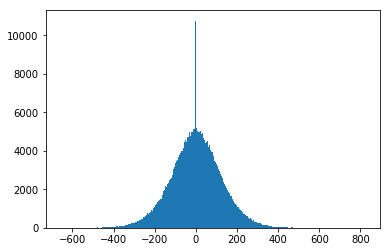

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(weights, bins='auto')